# Import libraries

In [3]:
import os
from datetime import datetime
import json
import pickle
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow_probability as tfp
import tensorflow as tf

from matplotlib import offsetbox
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import losses

plt.rcParams['figure.figsize'] = [13, 5]
from carla_visual.plotting.plot_output import plot_image


In [4]:
import carla_visual.recourse_methods.countergan.utils  as cutils
from carla_visual.recourse_methods.countergan. model import create_discriminator, create_generator, define_countergan

# Load data and pre-trained models

In [5]:
MODELS_WEIGHTS_PATH = r"D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\countergan\models_tf_weights"

In [6]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = (x_train / 255.).astype("float32")
x_test = (x_test / 255.).astype("float32")

DESIRED_CLASS = 9  # This is the target class that the generator will learn to synthetize
N_CLASSES = 10

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_flat = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

X_train = np.expand_dims(x_train, axis=-1)
X_test = np.expand_dims(x_test, axis=-1)

LOAD_AUTOENCODER_AND_CLASSIFIER = True

if LOAD_AUTOENCODER_AND_CLASSIFIER:
    classifier = load_model(f"{MODELS_WEIGHTS_PATH}/classifier.h5")
    y_prob = classifier.predict(X_test)
    accuracy = (y_prob.argmax(axis=1) == y_test.argmax(axis=1)).mean()
    print(f"Classifier accuracy test: {accuracy:.3f}")

    autoencoder = load_model(f"{MODELS_WEIGHTS_PATH}/autoencoder.h5",
                             custom_objects={'mse': losses.mse})
    reconstruction_error_test = cutils.compute_reconstruction_error(X_test, autoencoder)
    print(f"AE average reconstruction error: {reconstruction_error_test.mean():.3f}")

d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classifier accuracy test: 0.989


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
AE average reconstruction error: 3.660


In [5]:
generator = create_generator(residuals=True)
generator.load_weights(f"{MODELS_WEIGHTS_PATH}/generator.h5")

<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_83>
<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_84>


d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:
discriminator = create_discriminator()
discriminator.load_weights(f"{MODELS_WEIGHTS_PATH}/discriminator.h5")

In [7]:
countergan = define_countergan(generator, discriminator, classifier)
countergan.load_weights(f"{MODELS_WEIGHTS_PATH}/countergan.h5")

# Robustness evaluation 

In [21]:
counterfactuals = generator.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


Compare an instance from the test set and a generated counterfactual

In [22]:
test_image = X_test[0]
cf_image = counterfactuals[0]

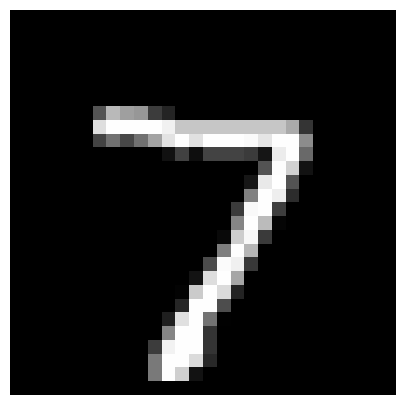

In [23]:
plot_image(test_image)

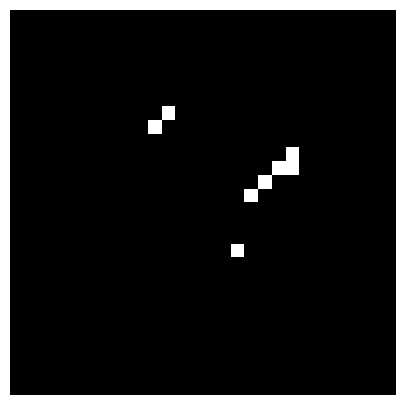

In [24]:
plot_image(cf_image)

Perturb the counterfactual and test the prediction of the classifier

(28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


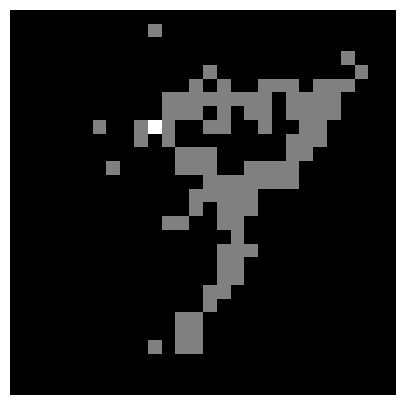

[[0 0 0 0 0 0 0 0 1 0]]


In [49]:
#noise = np.eye(28, 28) * 0.25
noise = np.random.rand(28, 28, 1)  # np.expand_dims(noise, axis=-1)
print(noise.shape)
noisy_cf_image = cf_image+noise
prediction = (classifier.predict(np.expand_dims(noisy_cf_image, axis=0)) > 0.5).astype(int)
plot_image(noisy_cf_image)
print(prediction)

In [51]:
classifier.predict(np.expand_dims(noisy_cf_image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[3.1045503e-05, 1.9874413e-05, 5.7319462e-02, 4.0387545e-02,
        1.1188907e-04, 2.2444339e-03, 7.5587263e-06, 1.5150759e-03,
        8.7679982e-01, 2.1563349e-02]], dtype=float32)

# Calculate Invalidation Rate

In [52]:
def perturb_sample(x, n_samples, sigma2):

    # stack copies of this sample, i.e. n rows of x.
    n = x.shape[1]
    X = np.tile(x, reps=(n_samples, 1, 1, 1))

    # sample normal distributed values
    Sigma = tf.eye(n) * sigma2
    eps = tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(n),
            scale_diag=Sigma
                  ).sample((n_samples,))
    eps = tf.expand_dims(eps, axis=-1)
    return X + eps, Sigma, eps

In [53]:
sigmas2 = [0.01, 0.015, 0.02, 0.025]
n_samples = 1000

In [57]:
rir_results = {}


for sigma in sigmas2:
    result = []
    for x in tqdm(counterfactuals[:1000]):
        if len(x.shape) < 4:
            x = tf.expand_dims(x, axis=0)
        cf_prediction = (classifier.predict(x, verbose=0) > 0.5).astype(int)
        cf_prediction = np.tile(cf_prediction, (n_samples, 1)) 

        X_pert, _, _ = perturb_sample(x, n_samples, sigma2=sigmas2[0])
        cf_pert_prediction = (classifier.predict(X_pert, verbose=0).squeeze() > 0.5).astype(int)
        delta_M = np.mean(np.all(cf_prediction - cf_pert_prediction, axis=1))

        result.append(delta_M)
    rir_results['sigma_'+str(sigma)] = result

100%|██████████| 1000/1000 [09:13<00:00,  1.81it/s]


In [63]:
rir_results_df = {k: pd.DataFrame(v) for k, v in rir_results.items()}
for key in rir_results_df.keys():
    print(rir_results_df[key].value_counts())

0.0    1000
dtype: int64
0.0    1000
dtype: int64
0.0    1000
dtype: int64
0.0    1000
dtype: int64


In [67]:
rir_results_df['sigma_0.01'].shape

(1000, 1)

C:\Users\sahat\AppData\Local\Temp\ipykernel_4032\1098059160.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(datasets, patch_artist=True, labels=labels)


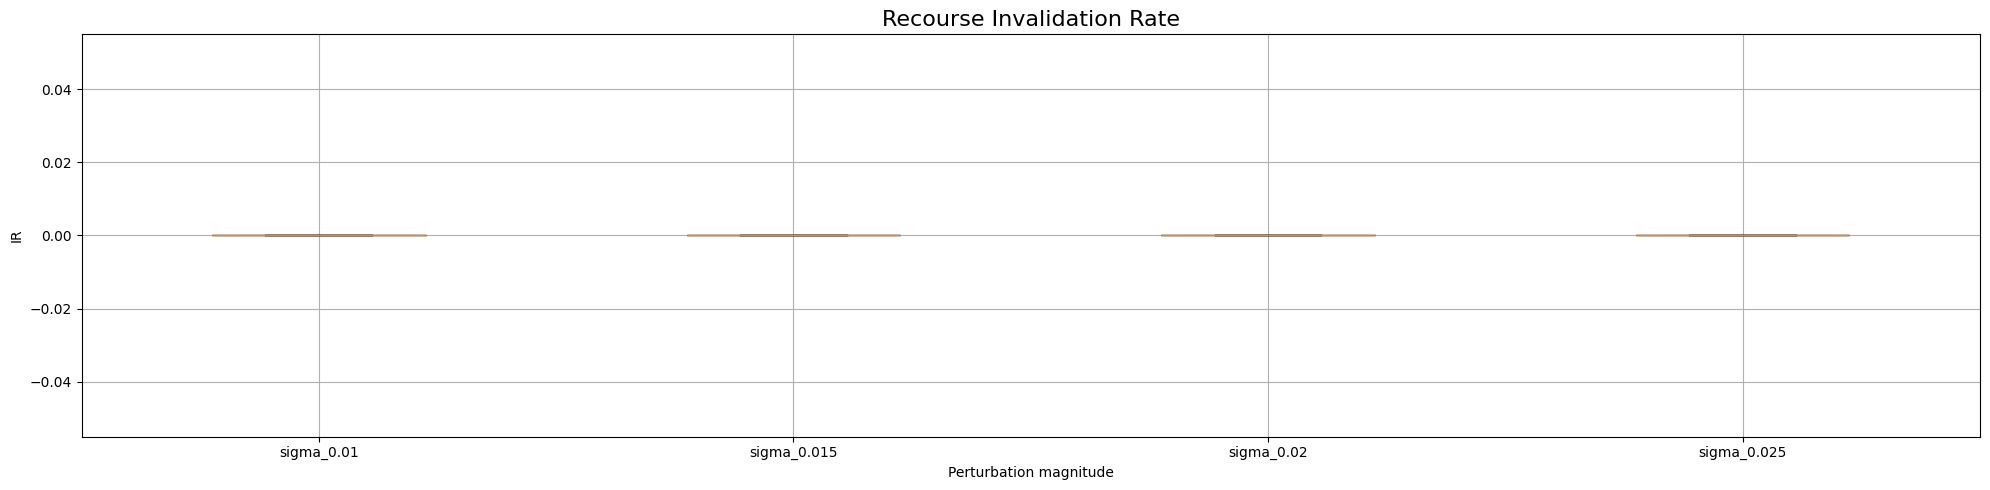

In [78]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(20, 5))

# Plotting the boxplots
datasets = pd.concat(list(rir_results_df.values()), axis=1)
labels = list(rir_results_df.keys())

box_plot = ax.boxplot(datasets, patch_artist=True, labels=labels)

# Customize boxplot colors
colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_xlabel('Perturbation magnitude')
ax.set_ylabel('IR')
ax.set_title('Recourse Invalidation Rate', fontsize=16)

# Add a grid for better readability
ax.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()